 # 3.4 Milvus周边功能

在本节中，我们将探讨 Milvus 的一些周边生态工具，展望 Milvus 在更多领域的应用前景，并为您推荐进一步学习的资源。


 ## Milvus 周边工具简述

Milvus 不仅仅是一个向量数据库，其生态系统还包括一系列强大的工具和特性，以满足企业级应用的需求。

 ### 1. [数据同步VTS (Vector Transport Service)](https://github.com/zilliztech/vts)

 **描述:**
 VTS（Vector Transport Service）是 Zilliz 开发的一个开源工具，专注于向量和非结构化数据的迁移。它基于 Apache SeaTunnel，适合处理数据从各种来源（如关系数据库、数据仓库、S3）到 Milvus 的迁移

 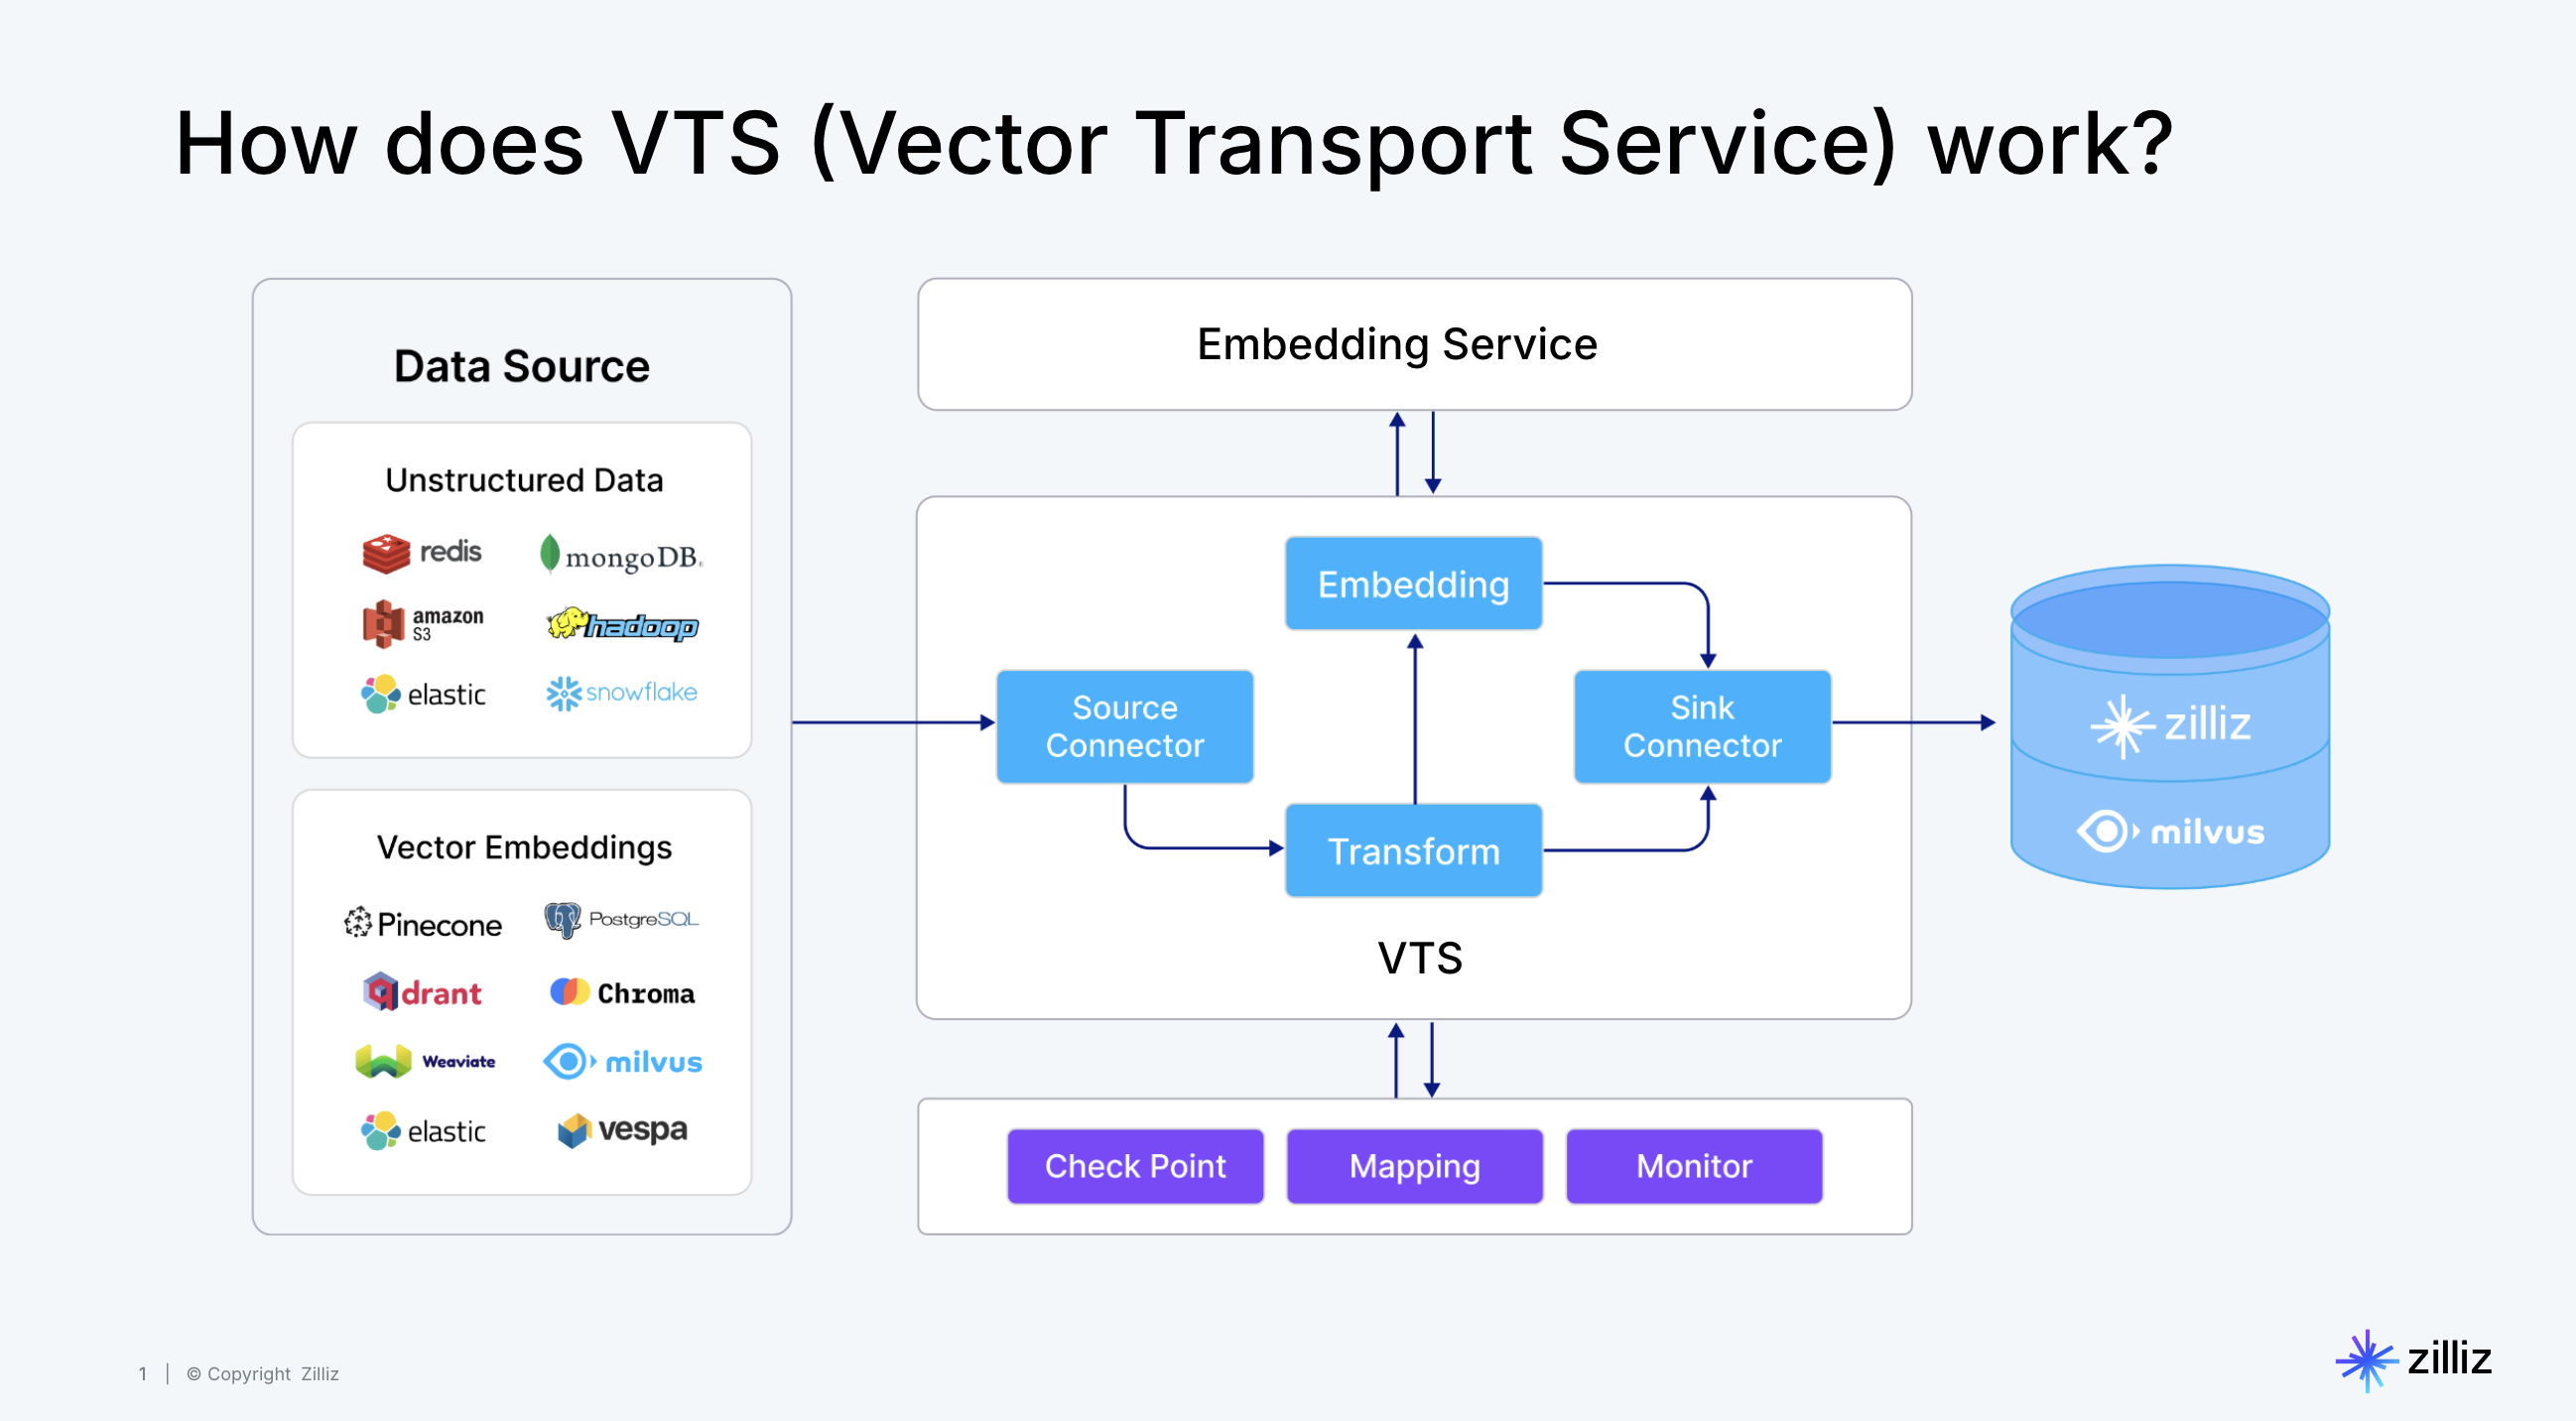

 **主要用途:**

 | **用途**                          | **描述**                                                                 |
|-----------------------------------|--------------------------------------------------------------------------|
| 数据迁移需求                      | 从 Milvus、Elasticsearch 等迁移到 Milvus，自动处理模式转换。              |
| 实时与离线支持                    | 提供实时数据流和离线批量导入，灵活适应不同场景。                          |
| 非结构化数据转换                  | 通过 AI 模型支持向量嵌入和标记，降低数据清洗成本。                        |
| 数据质量保证                      | 提供监控和警报机制，防止数据丢失和不一致。                                |
| AI 应用数据管道                   | 优化图像检索、推荐系统等场景，支持实时同步和加载。                        |
| 支持的数据源                      | Milvus、Elasticsearch、Solr、PostgreSQL、Pinecone、Qdrant 等。            |

 **使用方式:**
 通常是一个独立的命令行工具或配置文件驱动的服务。你需要指定源和目标 Milvus 实例（或文件路径），以及要迁移的集合。

 **示例 :**

- 安装 Docker，确保 Milvus 版本 >= 2.3.6。
- 拉取镜像并运行：`docker pull zilliz/vector-transport-service:latest`
- 配置迁移文件（如 migration.conf）
  ```
  env {
    parallelism = 1
    job.mode = "BATCH"
  }

  source {
    # Source configuration (e.g., Milvus, Elasticsearch, etc.)
    Milvus {
      url = "https://your-source-url:19530"
      token = "your-token"
      database = "default"
      collections = ["your-collection"]
      batch_size = 100
    }
  }
  
  sink {
    # Target configuration
    Milvus {
      url = "https://your-target-url:19530"
      token = "your-token"
      database = "default"
      batch_size = 10
    }
  }
  ```
- 然后运行命令如 `./bin/seatunnel.sh --config ./migration.conf`



 ### 2. [Milvus CDC (Change Data Capture)](https://github.com/zilliztech/milvus-cdc)

 **描述:**
 Milvus-CDC 是一个用户友好的工具，能够捕获和同步 Milvus 实例中的增量数据变化。它通过无缝地将数据从源实例传输到目标实例，确保业务数据的可靠性，支持增量备份和灾难恢复。其工作流程包括从源 Milvus 的 etcd 获取集合元数据，连接消息队列（MQ）订阅数据流，并通过 Go SDK 或其他方式处理数据以复制源实例的操作。

 **主要用途:**
 *  **提高数据可靠性**：通过捕获和同步增量数据，包括插入和删除操作，减少数据丢失的可能性。这对于需要持续数据一致性的应用尤为重要。  
 *  **灾难恢复**：实现 Milvus 的主备切换功能，确保即使源集群发生故障，上层服务仍能保持可用性。这对于高可用性架构至关重要。

 **工作原理:**
 CDC 工具会监听 Milvus 的数据操作日志（或通过特定API），并将变更事件推送到消息队列（如 Kafka, Pulsar）或直接提供给订阅者。

 ### 3. [Milvus Backup](https://github.com/zilliztech/milvus-backup)

 **描述:**
 Milvus Backup 是一个官方提供的命令行工具，用于备份和恢复 Milvus 实例的元数据和向量数据。它支持全量备份和增量备份。

 **主要优势:**
 *   **数据安全:** 防止因硬件故障、人为错误等导致的数据丢失。
 *   **灾难恢复:** 在发生灾难时，能够快速恢复 Milvus 服务。
 *   **常见使用场景:**
     - (1) 在同一个 Milvus 实例内备份与恢复
       -  同一 S3(或 MinIO) 环境，bucketName 和 rootPath 相同。
       - 备份某个集合后，通过加后缀(-s) 或重命名的方式恢复到同一实例内。
     - (2) 在一个 S3 存储服务，同一存储桶(bucket)但不同 Milvus 实例之间迁移
       - 两个实例可能具有不同的 rootPath，如 files_A 和 files_B。
       - 先在 Milvus_A 环境创建备份，再在 Milvus_B 环境中修改配置文件(使其指向同一 bucket，但 rootPath 不同)，执行 restore。
     - (3) 在一个 S3 存储服务，不同存储桶之间的迁移
       -  Milvus_A 与 Milvus_B 使用相同的 S3 地址，但 bucketName 不同，如 bucket_A 和 bucket_B。
       -  在 A 实例中创建备份后, 备份文件将写入 backupBucketName/backupRootPath 目录，B 实例再以自己的 bucket 恢复。
     - (4) 跨不同 S3 存储服务
       -  Milvus_A 和 Milvus_B 分别使用 minio_A 和 minio_B。
       - 在 Milvus_A 完成备份后，需手动将备份文件从 minio_A 迁移到 minio_B（例如使用 S3 copy 工具），然后在 Milvus_B 中执行 restore。

 **使用方式 (CLI 操作):**
 ```bash
 # 创建备份 
 milvus-backup create -n my_backup_job \
                    -c my_collection1,my_collection2 \
                    --milvus-host <milvus_host> \
                    --milvus-port <milvus_port> \
                    --backup-path s3://my-bucket/milvus-backups/

 # 恢复备份 
 milvus-backup restore -n my_backup_job \
                     -p s3://my-bucket/milvus-backups/my_backup_job_timestamp \
                     --milvus-host <target_milvus_host> \
                     --milvus-port <target_milvus_port>
 ```

**上述工具功能对比**

* **简化迁移**：利用 Vector Transport Service (VTS) 在平台之间移动数据，无论是从 Elastic/Pinecone/Qdrant 或者在 Milvus 部署之间进行迁移。
* **可靠备份**：使用 milvus-backup 工具在永久存储上创建快照，并在数据回滚或灾难恢复时进行恢复。
* **数据复制**：在生产环境中达到更高的可用性。您还可以通过 Milvus CDC 实现热冷集群设置。

 ### 4. [VectorDBBench](https://github.com/zilliztech/VectorDBBench)

 **描述:**
 VectorDBBench（VDBBench）是一个由 Zilliz 赞助的开源基准测试工具，专注于评估向量数据库的性能和成本效益，特别适合用于人工智能和机器学习应用中的向量数据库选择。

 **功能**

 - **基准测试案例**：包括 15 个全面的测试案例，分为容量测试、搜索性能测试和过滤搜索性能测试，使用公开数据集如 SIFT、GIST、Cohere 和 OpenAI 生成的数据，测量插入向量数、索引构建时间、召回率、延迟和最大 QPS。
 - **客户端支持**：支持 Milvus、Zilliz Cloud、Elastic Search、Pinecone、Qdrant Cloud、Weaviate Cloud、PgVector、Redis、Chroma 等，额外客户端可通过安装包启用。
 - **自定义数据集测试**：用户可上传 Parquet 格式的自定义数据集进行测试。
 - **性能排行榜**：提供在线排行榜 https://zilliz.com/benchmark，基于 QPS、QP$ 和延迟等指标比较系统

 **1.0**
 - 🚀 𝐑𝐞𝐝𝐞𝐬𝐢𝐠𝐧𝐞𝐝 𝐔𝐈：全新设计的首页和集成分析页面，让可视化和对比测试结果前所未有地轻松。
 - 🏷️ 𝐋𝐚𝐛𝐞𝐥-𝐅𝐢𝐥𝐭𝐞𝐫 𝐓𝐞𝐬𝐭𝐬：利用包含过滤表达式（如 “author = ‘Shakespeare’”）的新测试用例来模拟真实查询场景。通过元数据过滤与 ANN 搜索相结合所带来的检索方式，正逐渐成为比单纯向量搜索更主流的方案。
 - 🌊 𝐒𝐭𝐫𝐞𝐚𝐦𝐢𝐧𝐠 𝐒𝐜𝐞𝐧𝐚𝐫𝐢𝐨𝐬：在数据不断写入的同时，进行搜索性能测试，以评估“边写边读”的检索能力。
 - 🔬 𝐍𝐞𝐰 𝐁𝐢𝐨𝐀𝐒𝐏 𝐃𝐚𝐭𝐚𝐬𝐞𝐭：新增 1024 维向量数据集（包含 100 万和 1000 万向量），满足更高维度向量的性能测试需求。
 - ⚙️ 𝐂𝐮𝐬𝐭𝐨𝐦 𝐃𝐚𝐭𝐚𝐬𝐞𝐭𝐬：提供更多灵活的配置选项，让你能够创建贴合自身数据需求的数据集。

当前版本要求 `Python >= 3.11`，并通过 `pip install vectordb-bench` 安装。用户可以通过命令行（如 `vectordbbench --help`）或界面（如 init_bench）运行。


 ### 5. [Deep-searcher](https://github.com/zilliztech/deep-searcher)

 **描述:**
 
 DeepSearcher 是一个由 Zilliz 开发的开源项目，旨在为私有数据提供深度研究和搜索的替代方案。该工具通过 Retrieval-Augmented Generation (RAG) 技术构建，支持查询路由、条件执行流程和网络爬取等功能，是 agentic RAG 的展示案例。通过迭代细化查询、研究和分析信息，最终合成报告，适合需要深度研究的场景。
 
 Deep Research作为RAG迈向Agent的标志性应用已经成为行业关注的热点。这类应用不再是简单的按照预置的检索-生成流程执行，而是能够充分发挥大模型潜力，智能完成问题分解、多轮信息检索直到最终报告生成的完整研究流程 [DEEP RESEARCH AGENTS:A SYSTEMATIC EXAMINATION AND ROADMAP](https://arxiv.org/abs/2506.18096)

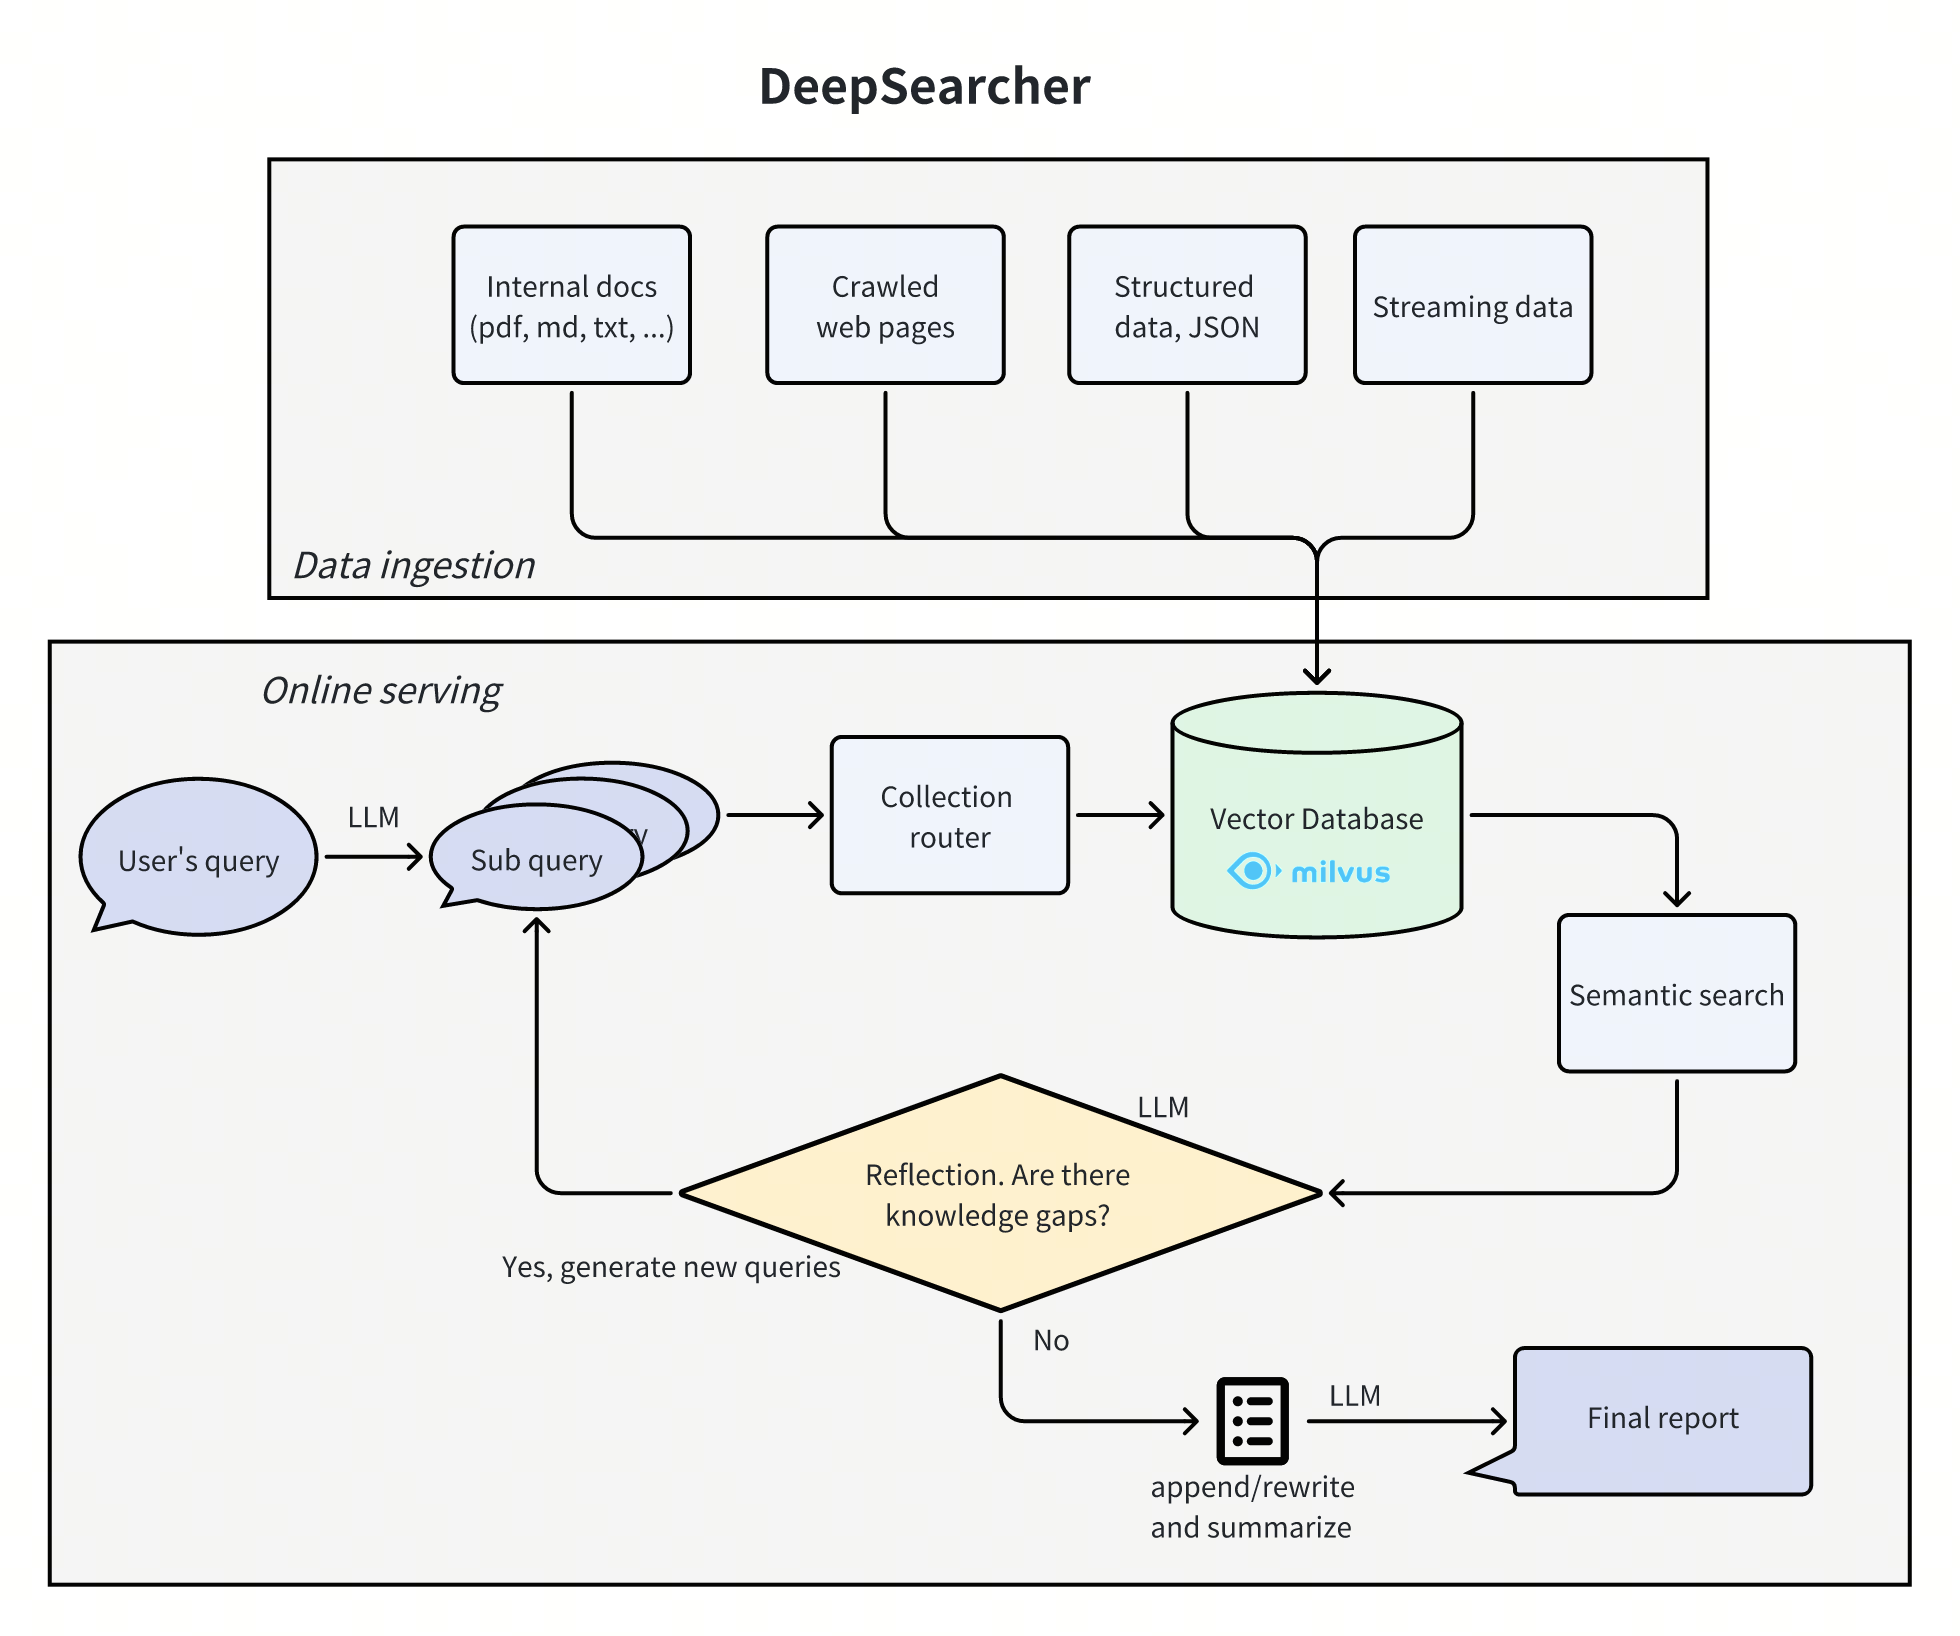

 **功能**
 *  **自动化深度研究**：它可以迭代研究一个主题或问题，通过浏览网络或内部文档，自动化推理以决定每一步的行动。  
 *  **合成报告**：将所有研究数据整合成一致的报告，通过单一提示生成，适合需要结构化输出的场景。  
 *  **企业知识管理**：帮助企业管理和检索知识，特别适用于处理内部文档。  
 *  **智能问答系统**：通过 RAG 技术，提供智能化的问答解决方案，适合信息检索和知识提取。  
 *  **信息检索场景**：适用于各种需要深度搜索和分析的场景，如学术研究或商业情报。

 **示例**

```python
from deepsearcher.configuration import Configuration, init_config
from deepsearcher.online_query import query

config = Configuration()

# Customize your config here,
# more configuration see the Configuration Details section below.
config.set_provider_config("llm", "OpenAI", {"model": "o1-mini"})
config.set_provider_config("embedding", "OpenAIEmbedding", {"model": "text-embedding-ada-002"})
init_config(config = config)

# Load your local data
from deepsearcher.offline_loading import load_from_local_files
load_from_local_files(paths_or_directory=your_local_path)

# (Optional) Load from web crawling (`FIRECRAWL_API_KEY` env variable required)
from deepsearcher.offline_loading import load_from_website
load_from_website(urls=website_url)

# Query
result = query("Write a report about xxx.") # Your question here
```





 ### 6. [MCP Server for Milvus](https://github.com/zilliztech/mcp-server-milvus)

 Demo: https://github.com/zilliztech/mcp-server-milvus/blob/main/Claude_mcp+1080.gif

 **如何快速上手 Zilliz MCP Server**
 - 第一步：注册或登录 https://zilliz.com/
 - 第二步：安装并运行 Zilliz MCP Server，链接：https://github.com/zilliztech/zilliz-mcp-server
 - 第三步：配置您的 AI 助手（如 Claude、Cursor、Windsurf 等）完成设置后，即可通过自然语言创建集合、插入向量、构建语义搜索，全面体验下一代对话式数据库开发方式。

 ### 7. 其它Milvus应用场景

Milvus 作为一款高性能的向量数据库，其应用场景远不止于基础的图像或文本相似性搜索。随着 AI 技术的发展，向量嵌入正成为表示各种复杂数据的通用方法，Milvus 的应用前景也因此变得更加广阔。

 ### 推荐系统 (Recommendation Systems)

 **核心思想:**
 将用户 (User) 和物品 (Item) 都表示为向量嵌入。
 *   **User Embedding:** 可以基于用户的历史行为（点击、购买、评分）、用户画像等生成。
 *   **Item Embedding:** 可以基于物品的内容特征（如商品描述、电影类型、音乐风格）或协同过滤模型生成。

 **Milvus 的作用:**
 1.  **存储 User 和 Item Embeddings:** 在 Milvus 中为用户和物品分别创建 Collection（或在同一 Collection 中用分区区分）。
 2.  **召回 (Recall):**
     *   **User-CF (User-based Collaborative Filtering):** 给定一个用户 A，在 Milvus 中搜索与其 Embedding 最相似的其他用户，然后推荐这些相似用户喜欢的物品。
     *   **Item-CF (Item-based Collaborative Filtering):** 给定一个用户 A 喜欢的物品 I，在 Milvus 中搜索与物品 I Embedding 最相似的其他物品，推荐给用户 A。
     *   **Embedding-based Retrieval:** 给定用户 A 的 Embedding，直接在 Item Embeddings 集合中搜索最相似的 K 个物品进行推荐。

**示例**： https://milvus.io/docs/movie_recommendation_with_milvus.md


 ### 异常检测 (Anomaly Detection)

 **核心思想:**
 “正常”的数据点在向量空间中会聚集形成簇，而“异常”的数据点通常会远离这些簇。

 **Milvus 的作用:**
 1.  **存储正常数据点的 Embeddings:**
     *   使用自编码器 (Autoencoder)、聚类算法 (如 K-Means) 或其他无监督/半监督方法，从大量“正常”数据中学习其特征表示（Embeddings）。
     *   将这些“正常”数据的 Embeddings 存入 Milvus。
 2.  **检测新数据点是否异常:**
     *   对于一个新的数据点，首先将其转换为同维度的 Embedding。
     *   在 Milvus 中搜索该 Embedding 的 K 个最近邻。
     *   **基于距离的异常判断:** 如果该 Embedding 与其最近邻的平均距离（或最大距离，或到第 K 个邻居的距离）超过某个预设阈值，则认为该点是异常点。
     *   **基于密度的异常判断:** 如果该 Embedding 的邻域内点的数量过少，也可能被视为异常。



 要深入学习和掌握 Milvus，以下是一些宝贵的资源：

 ### 1. 官方文档 (Official Documentation)
 *   **链接:** [https://milvus.io/docs](https://milvus.io/docs)
 *   **内容:** Milvus 的最权威和最全面的信息来源。包括安装指南、快速入门、API 参考、概念解释、最佳实践、各个工具的使用说明等。强烈建议从这里开始。

 ### 2. Milvus 社区 (Community)
 *   **Slack 频道:** [Milvus Slack](https://slack.milvus.io/)
     *   直接与 Milvus 开发者和全球用户交流、提问、分享经验。
 *   **GitHub Discussions:** [Milvus GitHub Discussions](https://github.com/milvus-io/milvus/discussions)
     *   一个提问、讨论功能、分享想法的好地方。
 *   **Zilliz 博客 / Milvus 博客:**
     *   [Zilliz Blog](https://zilliz.com/blog) (Zilliz 是 Milvus 背后的公司)
     *   通常会发布 Milvus 的最新动态、技术文章、案例研究等。
 *   **微信公众号 :** 搜索 "Zilliz" 或 "Milvus"，会有官方运营的公众号，提供中文资讯和活动信息。

   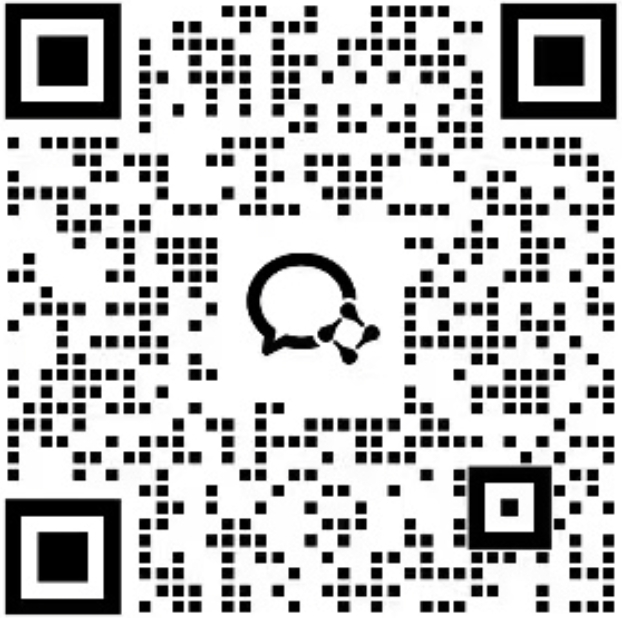

 ### 3. GitHub 仓库
 *   **Milvus 主仓库:** [https://github.com/milvus-io/milvus](https://github.com/milvus-io/milvus)
     *   Milvus 的源代码。可以提 Issue、查看源码、贡献代码。
 *   **Milvus Python SDK (PyMilvus):** [https://github.com/milvus-io/pymilvus](https://github.com/milvus-io/pymilvus)
     *   Python 客户端的源码和示例。
 *   **Milvus Java SDK:** [https://github.com/milvus-io/milvus-sdk-java](https://github.com/milvus-io/milvus-sdk-java)
 *   **Milvus Go SDK:** [https://github.com/milvus-io/milvus-sdk-go](https://github.com/milvus-io/milvus-sdk-go)
 *   **Milvus Node.js SDK:** [https://github.com/milvus-io/milvus-sdk-node](https://github.com/milvus-io/milvus-sdk-node)
 *   **Milvus C# SDK:** [https://github.com/milvus-io/milvus-sdk-csharp](https://github.com/milvus-io/milvus-sdk-csharp)
 *   **Milvus Operator:** [https://github.com/zilliztech/milvus-operator](https://github.com/zilliztech/milvus-operator)
     *   Kubernetes Operator 的源码。
 *   **Milvus Backup:** [https://github.com/zilliztech/milvus-backup](https://github.com/zilliztech/milvus-backup)
     *   备份与恢复工具的源码。
 *   **Milvus Sizing Tool:** [https://github.com/zilliztech/milvus-sizing-tool](https://github.com/zilliztech/milvus-sizing-tool)
     *   帮助评估 Milvus 部署所需资源的工具。
 *   **Milvus Examples / Bootcamp:**
     *   [https://github.com/milvus-io/bootcamp](https://github.com/milvus-io/bootcamp) (非常推荐!)
     *   包含了大量可以直接运行的示例代码，覆盖各种应用场景，是动手实践的好材料。

 ### 4. 教程和网络研讨会
 *   **YouTube 频道:** 搜索 "Milvus" 或 "Zilliz"。官方和社区会发布教程视频、网络研讨会录播等。
 *   **参与线上/线下 Meetup:** 关注 Milvus 社区动态，参与技术分享活动。